# LEELA Machine Learning
## Waveform Data
The data from LEELA comes in time-ordered "chunks" of 1024 samples. The sampling interval is about 9 $\mu$s. Each chunk is a structured numpy array which hold the actual waveform data and other information such as the peak centre time and the sampling interval amongst others.

The waveform data has been filtered using a bandpass filter which is centred at 10 kHz.  This is deemed to be roughly the peak frequency of the radio-frequency emissions from a lightning stroke.


We are interested in categorising Peak Detection Waveforms (PDWs) in some way.  These are the signals produced by lightning strikes.

The PDWs vary in length in time and multiples of them can occur in a chunk.  The numpy data within this repository are organised into 'peak centred waveforms' i.e a potential PDW is detected and the centre of that PDW is the centre of the chunk. This also means subsequent chunks contain the same PDWs! This is easier to see with examples.

Lets load in some data and have a look:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as sig
import numpy as np
import glob

In [2]:
 #load in all sets of waveform data
dunk_wvfms = np.load('Wfs_180921_1500_DUN_09000_5000_25.npy') #Dunkeswell detector
watn_wvfms = np.load('Wfs_180921_1500_WAT_09000_5000_25.npy') #Watnell detector
milf_wvfms = np.load('Wfs_180921_1500_MIL_09000_5000_25.npy') #Milford detector
tart_wvfms = np.load('Wfs_180921_1500_TAR_09000_5000_25.npy') #Tartu detector
hers_wvfms = np.load('Wfs_180921_1500_HER_09000_5000_25.npy') #Herstmonceux detector

<IPython.core.display.Javascript object>


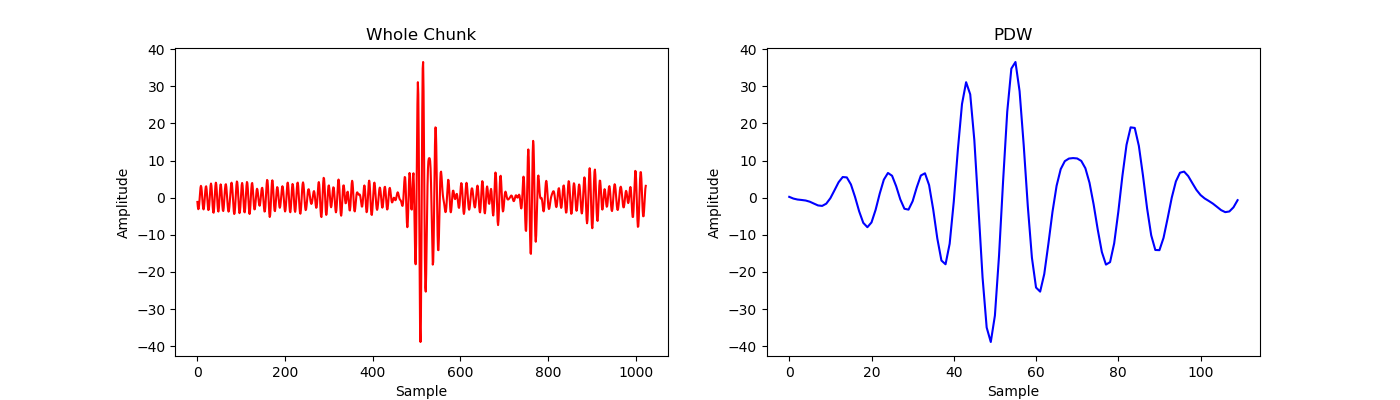

In [3]:
example_wvfm = dunk_wvfms[0]['wvfmdata'] #load in the actual waveform data for the first chunk

fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(example_wvfm, 'r-')
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Whole Chunk')

#Now plot the actual PDW (using guess work)
ax[1].plot(example_wvfm[460:570], 'b-')
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('PDW')

plt.show()


The plots above shows a single chunk from the data and the PDW from that chunk that I have roughly pulled out using guess work.

Let's look at an example of a chunk with multiple PDWs in.

<IPython.core.display.Javascript object>


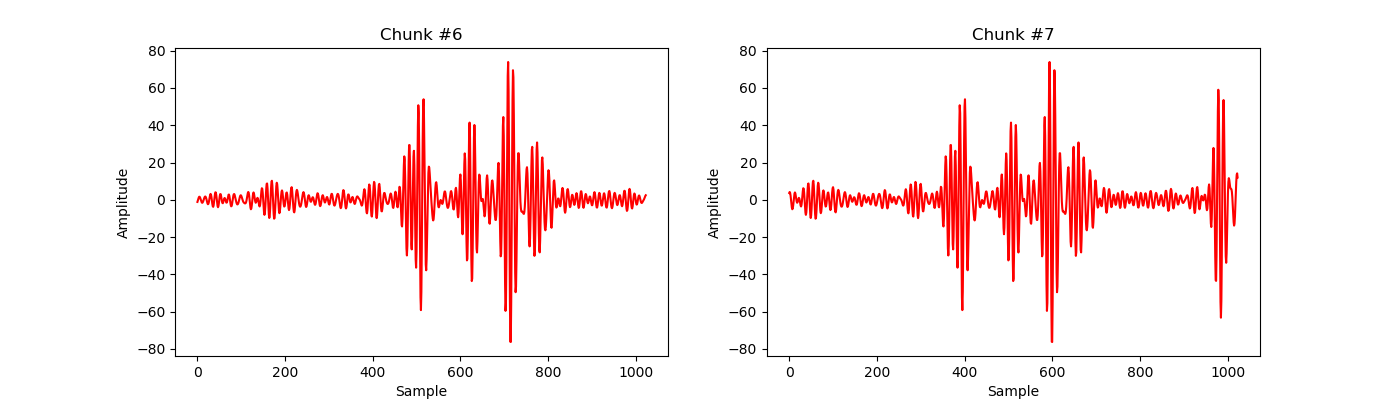

Text(0.5, 1.0, 'Chunk #7')

In [4]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
ax[0].plot(dunk_wvfms[5]['wvfmdata'], 'r-')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('Sample')
ax[0].set_title('Chunk #6')

ax[1].plot(dunk_wvfms[6]['wvfmdata'], 'r-')
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Sample')
ax[1].set_title('Chunk #7')

These two consecutive chunks display the same chain of four PDWs.  In the plot on the left, the first PDW in the chain is at the centre of the chunk. In the plot on the right, the next PDW in the chain is at the centre of the chunk.

We can't say for sure if the four PDWs in this chain are from the same event (a multi-stroke event) or are from separate single-stroke events.

## Machine Learning on Chunks
Since all chunks are of the same length, it is easy to produce a periodogram of them and use these and inputs for a neural network so lets start here and build a variational autoencoder.

First lets see and example of a chunk and its periodogram. The parameter nperseg was chosen as 64 to balance the time and frequency resolutions but is still probably not ideal.

<IPython.core.display.Javascript object>


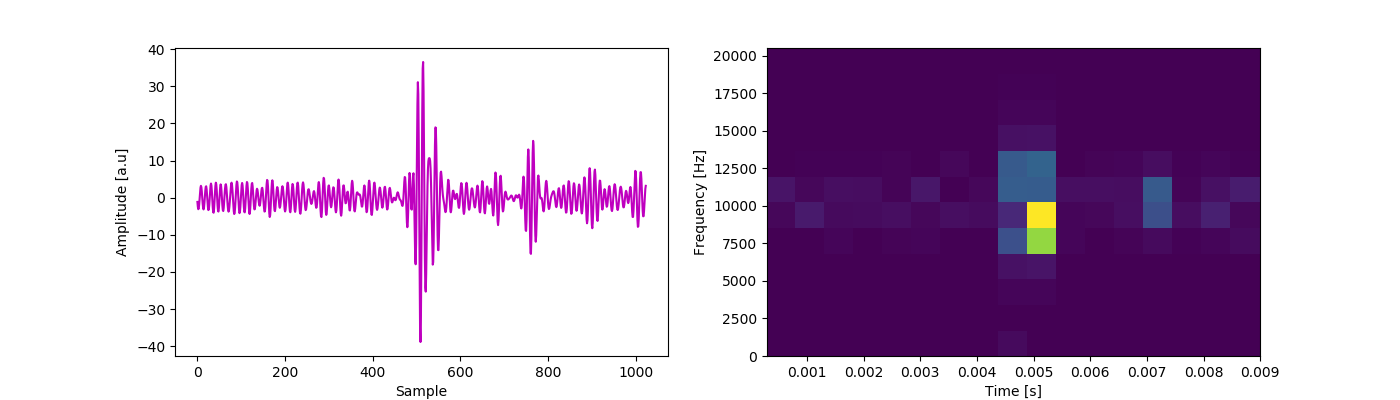

Text(0, 0.5, 'Frequency [Hz]')

In [5]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

ax[0].plot(example_wvfm, 'm-')
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Amplitude [a.u]')

DFT_LENGTH = 64
fmax = 22000
fmin = 0

sampling_freq = 1/dunk_wvfms[0]['sampleinterval']
f, t, Sxx = sig.spectrogram(example_wvfm, sampling_freq, nperseg=DFT_LENGTH)

freq_slice = np.where((f >= fmin) & (f <= fmax))
f   = f[freq_slice]
Sxx = Sxx[freq_slice, :][0]

Sxx = Sxx/Sxx.max() #normalise

ax[1].pcolormesh(t, f, Sxx)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Frequency [Hz]')


Now lets read in all chunks from all data sets, produce flattened periodograms for each and append them to an array.

In [6]:
x_train = [] 
for data_set in [dunk_wvfms, tart_wvfms, milf_wvfms, watn_wvfms, hers_wvfms]:
    for chunk in data_set:
        sampling_freq = 1/chunk['sampleinterval']
        f, t, Sxx = sig.spectrogram(chunk['wvfmdata'], sampling_freq, nperseg=DFT_LENGTH)
        freq_slice = np.where((f >= fmin) & (f <= fmax))
        Sxx = Sxx[freq_slice, :][0]
        Sxx = Sxx/Sxx.max()
        x_train.append(Sxx) #.flatten())
    
x_train = np.asarray(x_train)
print('Loaded in {} periodograms'.format(x_train.shape[0]))

Loaded in 3465 periodograms


## Variational Autoencoder

Now lets build a basic variational autoencoder using the [keras tutorial script](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py) so it runs at the very least.

After it has been trained we shall look at the latent space from the encoder network.

In [7]:
#import keras layers etc...
from keras.layers import Lambda, Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras import backend as ke

Using TensorFlow backend.


In [8]:
#set dimension parameters
periodogram_shape = x_train[0].shape
periodogram_size = x_train[0].size

kernel_size = 3
filters = 16

latent_dim = 3 #dimension of latent space

In [9]:
#Build encoder network with convolutional layers
print(periodogram_shape)
inputs = Input(shape=(periodogram_shape[0], periodogram_shape[1], 1), name='encoder_input')

x = inputs
for i in range(3):
    filters *= 2
    x = Conv2D(filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                strides=1,
                padding='same')(x)
        
        
_shape = ke.int_shape(x) #will use this to reshape data in decoder network
    
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

(13, 18)





In [10]:
#Function for reparameterization
def sampling(args):
    z_mean, z_log_var = args
    batch = ke.shape(z_mean)[0]
    dim = ke.int_shape(z_mean)[1]
    epsilon = ke.random_normal(shape=(batch, dim))
    return z_mean + ke.exp(0.5*z_log_var)*epsilon

#add reparameterization to encoder model
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [11]:
#Now build decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(_shape[1]*_shape[2]*_shape[3], activation='relu')(latent_inputs)
x = Reshape((_shape[1], _shape[2], _shape[3]))(x)

for i in range(3):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=1,
                        padding='same')(x)
    filters //= 2
    
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          strides=1,
                          name='decoder_output')(x)
    
    
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])

In [12]:
#Put encoder/decoder together to form Variational autoencoder
vae = Model(inputs, outputs, name='vae')

In [13]:
#Form loss function for VAE
#reconstruction_loss = binary_crossentropy(ke.flatten(inputs), ke.flatten(outputs))
reconstruction_loss = mse(ke.flatten(inputs), ke.flatten(outputs)) #Mean squared error

reconstruction_loss *= periodogram_size
kl_loss = 1 + z_log_var - ke.square(z_mean) - ke.exp(z_log_var)
kl_loss = ke.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = ke.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 13, 18, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 572022    
_________________________________________________________________
decoder (Model)              (None, 13, 18, 1)         359937    
Total params: 931,959
Trainable params: 931,959
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Train the VAE
data_shape = x_train.shape
x_train = x_train.reshape([data_shape[0], data_shape[1], data_shape[2], 1])
vae.fit(x_train, epochs=50)


Epoch 1/50
3465/3465 [==============================] - 30s 9ms/step - loss: 4.9936
Epoch 2/50
3465/3465 [==============================] - 27s 8ms/step - loss: 2.6876
Epoch 3/50
3465/3465 [==============================] - 26s 8ms/step - loss: 2.6876
Epoch 4/50
3465/3465 [==============================] - 26s 7ms/step - loss: 2.6876
Epoch 5/50
3465/3465 [==============================] - 27s 8ms/step - loss: 2.6876
Epoch 6/50
3465/3465 [==============================] - 26s 8ms/step - loss: 2.6876
Epoch 7/50
3465/3465 [==============================] - 26s 7ms/step - loss: 2.6876
Epoch 8/50
3465/3465 [==============================] - 27s 8ms/step - loss: 2.6876
Epoch 9/50
3465/3465 [==============================] - 26s 7ms/step - loss: 2.6876
Epoch 10/50
3465/3465 [==============================] - 22s 6ms/step - loss: 2.6876
Epoch 11/50
3465/3465 [==============================] - 23s 7ms/step - loss: 2.6876
Epoch 12/50
3465/3465 [==============================] - 25s 7ms/step - l

<IPython.core.display.Javascript object>


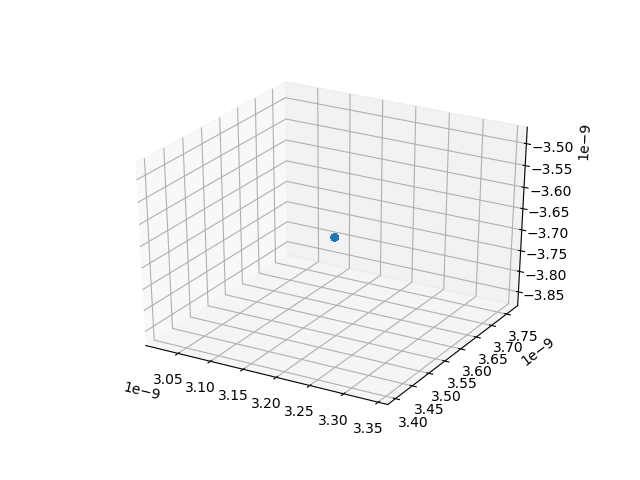

In [15]:
#Now plot latent space from encoder network
z_mean, z_log_sig, z = encoder.predict(x_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:, 2])
plt.show()

<IPython.core.display.Javascript object>


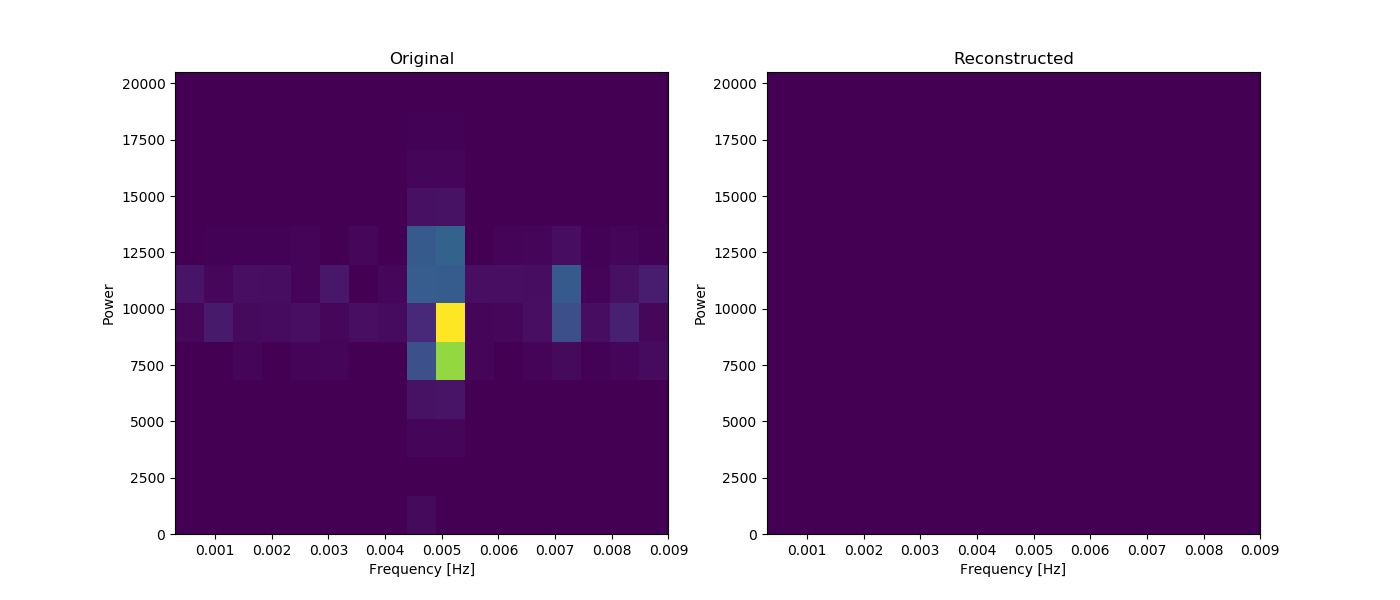

Text(0.5, 1.0, 'Reconstructed')

In [16]:
#lets look at a single 'reconstruction'
NUM = 0
event = x_train[0]

fig, ax = plt.subplots(1,2, figsize=(14, 6))
f = f[freq_slice]

ax[0].pcolormesh(t, f, event.reshape(f.size, t.size))
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Power')
ax[0].set_title('Original')

recon_event = vae.predict(np.asarray([event]))

ax[1].pcolormesh(t, f, recon_event[0].reshape(f.size, t.size))
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Power')
ax[1].set_title('Reconstructed')